In [28]:
import os
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.models import Model
import scipy
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from matplotlib.patches import Rectangle
from skimage.feature.peak import peak_local_max
import random 
import joblib

In [7]:
input_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset/')
output_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8,.2))

Copying files: 7324 files [00:30, 241.69 files/s]


In [8]:
train_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/train/')
val_dir = os.path.join('C:/Users/lydia/Documents/GitHub/Stroke_Daignosis_Detection/Dataset2/val/')

In [11]:
def image_generator(train_parent_directory, val_parent_directory):
    train_datagen = ImageDataGenerator(rescale=1/255)
    val_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                       target_size=(224,224),
                                                        batch_size=140,
                                                        class_mode='categorical',
                                                        subset='training')
    
    val_generator = val_datagen.flow_from_directory(val_parent_directory,
                                                     target_size=(224,224),
                                                      batch_size=37,
                                                      class_mode='categorical')
    
    return train_generator, val_generator

In [12]:
train_generator, val_generator = image_generator(train_dir, val_dir)

Found 5859 images belonging to 2 classes.
Found 1465 images belonging to 2 classes.


In [13]:
tfd = tfp.distributions
tfpl = tfp.layers

In [14]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/8569

model_bayes = Sequential([

        tfpl.Convolution2DReparameterization(input_shape=(224,224,3), filters=4, kernel_size=8, activation='relu',
                                               kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                               kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                               kernel_divergence_fn = divergence_fn,
                                               bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                               bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                               bias_divergence_fn = divergence_fn),
        MaxPooling2D(2,2),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                        kernel_divergence_fn = divergence_fn,
                                        bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                        bias_divergence_fn = divergence_fn
                                    ),
        tfpl.OneHotCategorical(2)

    ])
    
model_bayes.summary()

D:\Anaconda\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
D:\Anaconda\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 217, 217, 4)      1544      
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 4)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 106, 106, 32)      1184      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 64)        18496     
                                                        

In [34]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [35]:
history_bayes = model_bayes.fit(
      train_generator,
      validation_data=val_generator,
      epochs=500,
      verbose=1)

Epoch 1/500
42/42 [==============================] - 140s 3s/step - loss: 0.2907 - accuracy: 0.9998 - val_loss: 0.3195 - val_accuracy: 0.9973
Epoch 2/500
42/42 [==============================] - 138s 3s/step - loss: 0.2898 - accuracy: 1.0000 - val_loss: 0.3225 - val_accuracy: 0.9980
Epoch 3/500
42/42 [==============================] - 137s 3s/step - loss: 0.2893 - accuracy: 0.9998 - val_loss: 0.3070 - val_accuracy: 0.9980
Epoch 4/500
42/42 [==============================] - 139s 3s/step - loss: 0.2885 - accuracy: 1.0000 - val_loss: 0.3067 - val_accuracy: 0.9980
Epoch 5/500
42/42 [==============================] - 143s 3s/step - loss: 0.2886 - accuracy: 0.9997 - val_loss: 0.3171 - val_accuracy: 0.9980
Epoch 6/500
42/42 [==============================] - 140s 3s/step - loss: 0.2877 - accuracy: 0.9995 - val_loss: 0.2952 - val_accuracy: 0.9973
Epoch 7/500
42/42 [==============================] - 137s 3s/step - loss: 0.2870 - accuracy: 0.9997 - val_loss: 0.3066 - val_accuracy: 0.9966
Epoch 

42/42 [==============================] - 139s 3s/step - loss: 0.2597 - accuracy: 0.9995 - val_loss: 0.2820 - val_accuracy: 0.9966
Epoch 59/500
42/42 [==============================] - 141s 3s/step - loss: 0.2583 - accuracy: 0.9998 - val_loss: 0.2789 - val_accuracy: 0.9973
Epoch 60/500
42/42 [==============================] - 140s 3s/step - loss: 0.2578 - accuracy: 0.9997 - val_loss: 0.2701 - val_accuracy: 0.9986
Epoch 61/500
42/42 [==============================] - 139s 3s/step - loss: 0.2572 - accuracy: 0.9998 - val_loss: 0.2673 - val_accuracy: 0.9986
Epoch 62/500
42/42 [==============================] - 140s 3s/step - loss: 0.2565 - accuracy: 1.0000 - val_loss: 0.2677 - val_accuracy: 0.9980
Epoch 63/500
42/42 [==============================] - 143s 3s/step - loss: 0.2560 - accuracy: 0.9998 - val_loss: 0.2733 - val_accuracy: 0.9986
Epoch 64/500
42/42 [==============================] - 153s 4s/step - loss: 0.2554 - accuracy: 1.0000 - val_loss: 0.2734 - val_accuracy: 0.9973
Epoch 65/500

42/42 [==============================] - 140s 3s/step - loss: 0.2272 - accuracy: 1.0000 - val_loss: 0.2523 - val_accuracy: 0.9966
Epoch 116/500
42/42 [==============================] - 140s 3s/step - loss: 0.2272 - accuracy: 1.0000 - val_loss: 0.2479 - val_accuracy: 0.9980
Epoch 117/500
42/42 [==============================] - 139s 3s/step - loss: 0.2266 - accuracy: 0.9997 - val_loss: 0.2408 - val_accuracy: 0.9973
Epoch 118/500
42/42 [==============================] - 141s 3s/step - loss: 0.2277 - accuracy: 0.9995 - val_loss: 0.2522 - val_accuracy: 0.9945
Epoch 119/500
42/42 [==============================] - 140s 3s/step - loss: 0.2257 - accuracy: 0.9995 - val_loss: 0.2422 - val_accuracy: 0.9973
Epoch 120/500
42/42 [==============================] - 141s 3s/step - loss: 0.2252 - accuracy: 0.9998 - val_loss: 0.2379 - val_accuracy: 0.9986
Epoch 121/500
42/42 [==============================] - 141s 3s/step - loss: 0.2243 - accuracy: 0.9997 - val_loss: 0.2404 - val_accuracy: 0.9973
Epoch 

Epoch 172/500
42/42 [==============================] - 139s 3s/step - loss: 0.2011 - accuracy: 0.9997 - val_loss: 0.2171 - val_accuracy: 0.9980
Epoch 173/500
42/42 [==============================] - 139s 3s/step - loss: 0.2020 - accuracy: 0.9993 - val_loss: 0.2093 - val_accuracy: 0.9986
Epoch 174/500
42/42 [==============================] - 139s 3s/step - loss: 0.1996 - accuracy: 0.9997 - val_loss: 0.2087 - val_accuracy: 0.9993
Epoch 175/500
42/42 [==============================] - 140s 3s/step - loss: 0.1997 - accuracy: 0.9995 - val_loss: 0.2245 - val_accuracy: 0.9980
Epoch 176/500
42/42 [==============================] - 138s 3s/step - loss: 0.1999 - accuracy: 0.9995 - val_loss: 0.2313 - val_accuracy: 0.9980
Epoch 177/500
42/42 [==============================] - 140s 3s/step - loss: 0.1981 - accuracy: 1.0000 - val_loss: 0.2212 - val_accuracy: 0.9980
Epoch 178/500
42/42 [==============================] - 140s 3s/step - loss: 0.1980 - accuracy: 0.9997 - val_loss: 0.2281 - val_accuracy:

Epoch 229/500
42/42 [==============================] - 138s 3s/step - loss: 0.1746 - accuracy: 0.9998 - val_loss: 0.1989 - val_accuracy: 0.9980
Epoch 230/500
42/42 [==============================] - 139s 3s/step - loss: 0.1742 - accuracy: 0.9998 - val_loss: 0.2108 - val_accuracy: 0.9980
Epoch 231/500
42/42 [==============================] - 139s 3s/step - loss: 0.1740 - accuracy: 0.9998 - val_loss: 0.2077 - val_accuracy: 0.9980
Epoch 232/500
42/42 [==============================] - 138s 3s/step - loss: 0.1733 - accuracy: 0.9998 - val_loss: 0.1966 - val_accuracy: 0.9973
Epoch 233/500
42/42 [==============================] - 139s 3s/step - loss: 0.1728 - accuracy: 1.0000 - val_loss: 0.1923 - val_accuracy: 0.9973
Epoch 234/500
42/42 [==============================] - 138s 3s/step - loss: 0.1723 - accuracy: 1.0000 - val_loss: 0.1846 - val_accuracy: 0.9980
Epoch 235/500
42/42 [==============================] - 140s 3s/step - loss: 0.1726 - accuracy: 0.9997 - val_loss: 0.1877 - val_accuracy:

Epoch 286/500
42/42 [==============================] - 136s 3s/step - loss: 0.1516 - accuracy: 0.9998 - val_loss: 0.1757 - val_accuracy: 0.9980
Epoch 287/500
42/42 [==============================] - 136s 3s/step - loss: 0.1530 - accuracy: 0.9991 - val_loss: 0.1684 - val_accuracy: 0.9973
Epoch 288/500
42/42 [==============================] - 136s 3s/step - loss: 0.1507 - accuracy: 0.9995 - val_loss: 0.1642 - val_accuracy: 0.9986
Epoch 289/500
42/42 [==============================] - 136s 3s/step - loss: 0.1505 - accuracy: 0.9998 - val_loss: 0.1727 - val_accuracy: 0.9986
Epoch 290/500
42/42 [==============================] - 136s 3s/step - loss: 0.1504 - accuracy: 0.9997 - val_loss: 0.1799 - val_accuracy: 0.9980
Epoch 291/500
42/42 [==============================] - 136s 3s/step - loss: 0.1495 - accuracy: 1.0000 - val_loss: 0.1658 - val_accuracy: 0.9980
Epoch 292/500
42/42 [==============================] - 137s 3s/step - loss: 0.1502 - accuracy: 0.9997 - val_loss: 0.1824 - val_accuracy:

Epoch 343/500
42/42 [==============================] - 136s 3s/step - loss: 0.1323 - accuracy: 0.9997 - val_loss: 0.1695 - val_accuracy: 0.9980
Epoch 344/500
42/42 [==============================] - 136s 3s/step - loss: 0.1352 - accuracy: 0.9995 - val_loss: 0.1824 - val_accuracy: 0.9966
Epoch 345/500
42/42 [==============================] - 136s 3s/step - loss: 0.1330 - accuracy: 0.9995 - val_loss: 0.1917 - val_accuracy: 0.9980
Epoch 346/500
42/42 [==============================] - 136s 3s/step - loss: 0.1318 - accuracy: 0.9995 - val_loss: 0.1335 - val_accuracy: 0.9993
Epoch 347/500
42/42 [==============================] - 136s 3s/step - loss: 0.1307 - accuracy: 1.0000 - val_loss: 0.1450 - val_accuracy: 0.9986
Epoch 348/500
42/42 [==============================] - 136s 3s/step - loss: 0.1305 - accuracy: 1.0000 - val_loss: 0.1559 - val_accuracy: 0.9966
Epoch 349/500
42/42 [==============================] - 136s 3s/step - loss: 0.1301 - accuracy: 0.9997 - val_loss: 0.1540 - val_accuracy:

Epoch 400/500
42/42 [==============================] - 135s 3s/step - loss: 0.1150 - accuracy: 0.9998 - val_loss: 0.1595 - val_accuracy: 0.9980
Epoch 401/500
42/42 [==============================] - 135s 3s/step - loss: 0.1155 - accuracy: 0.9998 - val_loss: 0.1502 - val_accuracy: 0.9980
Epoch 402/500
42/42 [==============================] - 135s 3s/step - loss: 0.1147 - accuracy: 0.9998 - val_loss: 0.1574 - val_accuracy: 0.9980
Epoch 403/500
42/42 [==============================] - 135s 3s/step - loss: 0.1141 - accuracy: 1.0000 - val_loss: 0.1326 - val_accuracy: 0.9980
Epoch 404/500
42/42 [==============================] - 136s 3s/step - loss: 0.1140 - accuracy: 0.9998 - val_loss: 0.1526 - val_accuracy: 0.9966
Epoch 405/500
42/42 [==============================] - 136s 3s/step - loss: 0.1135 - accuracy: 1.0000 - val_loss: 0.1286 - val_accuracy: 0.9986
Epoch 406/500
42/42 [==============================] - 135s 3s/step - loss: 0.1132 - accuracy: 1.0000 - val_loss: 0.1309 - val_accuracy:

Epoch 457/500
42/42 [==============================] - 136s 3s/step - loss: 0.1005 - accuracy: 0.9998 - val_loss: 0.1058 - val_accuracy: 0.9980
Epoch 458/500
42/42 [==============================] - 135s 3s/step - loss: 0.1003 - accuracy: 0.9997 - val_loss: 0.1141 - val_accuracy: 0.9986
Epoch 459/500
42/42 [==============================] - 135s 3s/step - loss: 0.1000 - accuracy: 0.9998 - val_loss: 0.1073 - val_accuracy: 0.9993
Epoch 460/500
42/42 [==============================] - 136s 3s/step - loss: 0.1005 - accuracy: 0.9998 - val_loss: 0.1073 - val_accuracy: 0.9986
Epoch 461/500
42/42 [==============================] - 135s 3s/step - loss: 0.1036 - accuracy: 0.9991 - val_loss: 0.1222 - val_accuracy: 0.9973
Epoch 462/500
42/42 [==============================] - 135s 3s/step - loss: 0.1005 - accuracy: 0.9995 - val_loss: 0.1260 - val_accuracy: 0.9973
Epoch 463/500
42/42 [==============================] - 136s 3s/step - loss: 0.0991 - accuracy: 1.0000 - val_loss: 0.1211 - val_accuracy:

In [36]:
_,train_acc = model_bayes.evaluate(train_generator)
print('Accuracy of train datasets = ', (train_acc * 100.0), "%")

_,valid_acc = model_bayes.evaluate(val_generator)
print('Accuracy of valid datasets = ', (valid_acc * 100.0), "%")

42/42 [==============================] - 31s 737ms/step - loss: 0.0914 - accuracy: 1.0000
Accuracy of train datasets =  100.0 %
40/40 [==============================] - 7s 182ms/step - loss: 0.1343 - accuracy: 0.9980
Accuracy of valid datasets =  99.79522228240967 %


In [37]:
size = 224
dataset = []
label = []

pneumothorax_images = os.listdir('Dataset2/test/Stroke/')
for i, image_name in enumerate(pneumothorax_images):
    image = cv2.imread('Dataset2/test/Stroke/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(1)
        
normal_images = os.listdir('Dataset2/test/Normal/')
for i, image_name in enumerate(normal_images):
    image = cv2.imread('Dataset2/test/Normal/' + image_name)
    image = Image.fromarray(image)
    image = image.resize((size,size))
    dataset.append(np.array(image))
    label.append(0)

dataset = np.array(dataset)
label = np.array(label)

In [38]:
X_test = dataset
y_test = label

In [39]:
X_test = X_test/255.
y_test = to_categorical(y_test)

79/79 [==============================] - 7s 89ms/step


<Axes: >

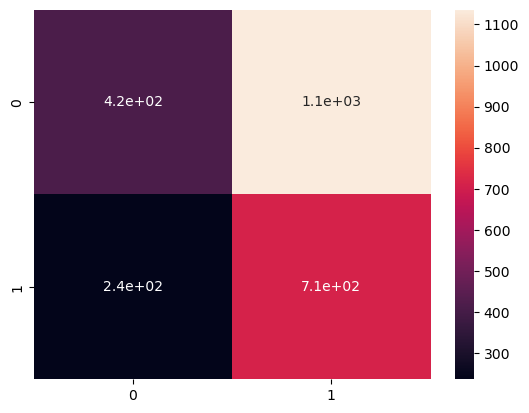

In [41]:
y_pred = np.argmax(model_bayes.predict(X_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
sns.heatmap(cm, annot=True)

In [29]:
pneumothorax_images_idx = np.where(y_pred == 1)[0]
predicted_as_para = []
for i in pneumothorax_images_idx:
    pneu_img = X_test[i]
    predicted_as_para.append(pneu_img)
    
predicted_as_para = np.array(predicted_as_para)

In [32]:
def plot_heatmap(img):
    pred = model_bayes.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    last_layer_weights = model_bayes.layers[-1].get_weights()[0]
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    last_conv_model = Model(model_bayes.input, model_bayes.get_layer("one_hot_categorical").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 64)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    heat_map[img[:,:,0] == 0] = 0 
     
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10) 

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.30)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))


In [33]:
image = random.randint(0,predicted_as_para.shape[0]-1)
heat_map = plot_heatmap(predicted_as_para[image])

img = predicted_as_para[image]
plt.imshow(predicted_as_para[img])

1/1 [==============================] - 0s 34ms/step


IndexError: list index out of range

In [43]:
joblib.dump(history_bayes, 'bayesian_model.joblib')

D:\Anaconda\lib\site-packages\keras\saving\serialization_lib.py:139: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         lambda t: OneHotCategorical.new(  # pylint: disable=g-long-lambda
            t, event_size, sample_dtype, validate_args),

  return [serialize_keras_object(x) for x in obj]


['bayesian_model.joblib']